In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
from funcs.qnm_selecting_funcs import *
import corner
import scipy
import pickle 

In [ ]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
new_times = np.arange(sim_main.times[0], sim_main.times[-1], 0.01)
sim_main = sim_interpolator(sim_main, new_times)


# TODO investigate why interpolating to coarser time steps reduces the contour size 

n_max = 6

t0 = 10
T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [96]:
with open('tuned_params.pkl', 'rb') as f:
    tuned_params = pickle.load(f)

tuned_params_lm = tuned_params[id]

In [97]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

In [98]:
with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3996582031249995]  
#tuning_hyperparams = [1.2045142510058162, -0.010490761448761522, 3.5999456915185255, 0.4832915123677303]

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_s = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

In [99]:
fit_s = qnm_BGP_fit(sim_main.times, sim_main.h, qnm_list, Mf_0, chif_mag_0, t0, tuned_param_dict_s, kernel_s, T=T, spherical_modes=spherical_modes)
fit = qnm_BGP_fit(sim_main.times, sim_main.h, qnm_list, Mf_0, chif_mag_0, t0, tuned_params_lm, kernel_main, T=T, spherical_modes=spherical_modes)

In [100]:
param_list = [qnm for qnm in qnm_list for _ in range(2)]
parameter_choice = [(2,2,0,1), (2,2,6,1)]

marginal_mean_s, marginal_fisher_s = marginalise(parameter_choice, param_list, fit_s["mean"], fit_s["fisher_matrix"])
marginal_mean, marginal_fisher = marginalise(parameter_choice, param_list, fit["mean"], fit["fisher_matrix"])

marginal_covariance = np.linalg.inv(marginal_fisher)    
marginal_covariance_s = np.linalg.inv(marginal_fisher_s)

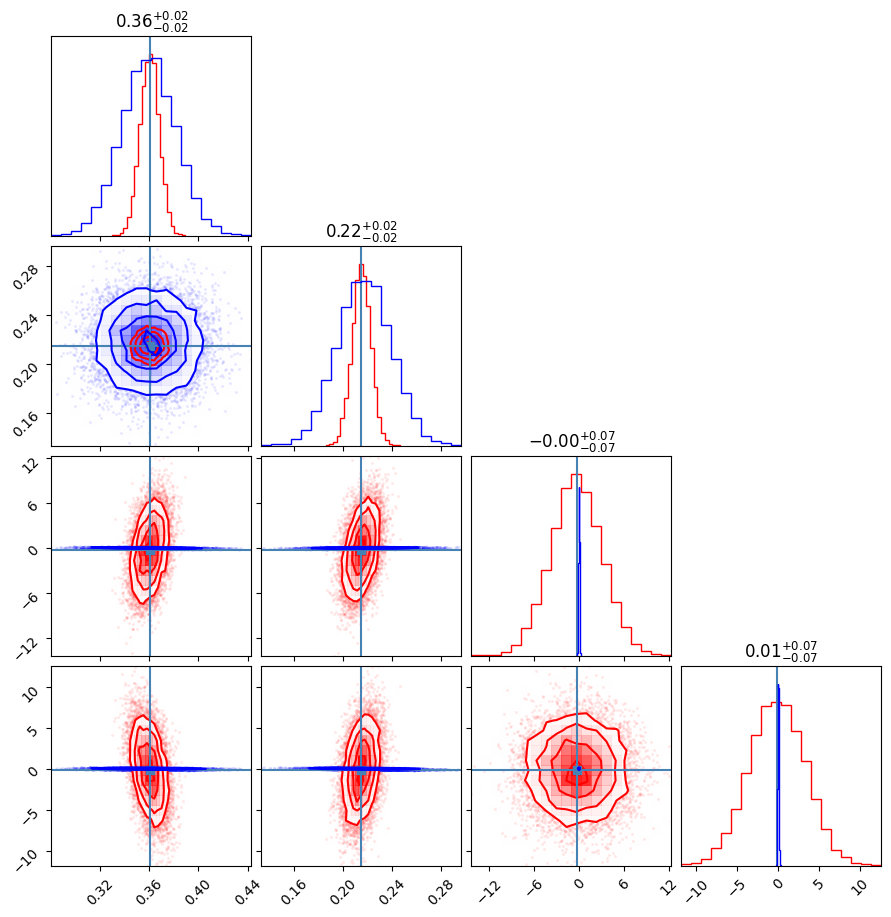

In [101]:
samples_s = scipy.stats.multivariate_normal(marginal_mean_s, marginal_covariance_s, allow_singular=True).rvs(
    size=10000
)

samples = scipy.stats.multivariate_normal(marginal_mean, marginal_covariance, allow_singular=True).rvs(
    size=10000
)

indices = [i for i, param in enumerate(param_list) if param in parameter_choice]

figure = corner.corner(
    samples_s,
    truths=[true_params[i] for i in indices],
    color='red',
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

figure = corner.corner(
    samples,
    color='blue',
    fig=figure,
    label_kwargs={"fontsize": 12},
    show_titles=True,
    title_kwargs={"fontsize": 12}
) 

plt.show()